<a href="https://colab.research.google.com/github/JiahaoLU/CTRPrediction/blob/Jiahao/CTRPrediction_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import numpy as np
import math
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader


class DataPreprocessor(Dataset):

    def __init__(self, path=None):
        """
        Initialise the preprocessor as a Data set in torch
        or initialise it as a data provider (cut smaller data, etc)
        :param path: file path
        """
        if path is not None:
            self.path = path
            self.data = self.read_data_by_chunk()
            self.labels = np.asarray(self.data.iloc[:, 1])
            self.one_hot_data = self.get_one_hot_dataset()
            print('Data set initiated from {0}.'.format(self.path))
        else:
            self.path = './Data/train.csv'
            print('Data provider is ready.')

    def __len__(self):
        """
        return number of data
        """
        return np.size(self.one_hot_data, 0)

    def __getitem__(self, index):
        """
        called when iterate on Data Loader
        :param index: index of one sample
        :return: one hot encoding of a sample, which consists of field-relative index of value 1,
                 and corresponding label
        """
        return self.one_hot_data[index], self.labels[index]

    def open_csv(self, iterator=False):
        """
        Open a csv file
        :param iterator: Open a csv file as iterator/or not
        :return: pandas data frame
        """
        try:
            csv_file = pd.read_csv(self.path, sep=',', engine='python', iterator=iterator)
            if csv_file is None:
              print("file empty")
            return csv_file
        except FileNotFoundError:
            print("file not found")

    def cut_smaller_data_for_exam(self, new_path, size=2000, skip_size=40000):
        """
        Cut a smaller data set for debugging code of size (smaller_data_size, num_fields + 2)
        :param new_path: name and path for new csv file
        :param size: the size of the smaller data set
        :param skip_size: interval to skip to retrieve data uniformly from original set
        :return: none
        """
        print("Producing smaller data")
        print("Read file")
        data_file = self.open_csv(iterator=True)

        print("cut by chunk")
        chunk_size = 100
        loops = math.floor(size/chunk_size)
        chunks = []
        for loop in range(loops * 2):
            try:
                print("chunk: ", loop)
                if loop % 2 == 0:  # avoid load data of same timestamp
                    chunk = data_file.get_chunk(chunk_size)
                    chunks.append(chunk)
                else:
                    chunk = data_file.get_chunk(skip_size)
                    del chunk
            except StopIteration:
                print("Iteration is stopped.")

        print('Start concatenation')
        data_frame = pd.concat(chunks, ignore_index=True)

        if os.path.exists(new_path):
            os.remove(new_path)
        data_frame.to_csv(new_path, index=False)
        print("New smaller file created")

    def read_data_by_chunk(self, chunk_size=1000000):
        """
        Read csv by chunk to avoid drive memory overflow
        :param chunk_size: the size of data to read in every chunk
        :return: csv registered in pandas data frame of size (data_size, num_fields + 2)
        """
        print("Reading large data")
        data_file = self.open_csv(iterator=True)

        print("Cut by chunk")
        loop = True
        chunks = []
        index = 0
        while loop:
            try:
                print("chunk: ", index)
                chunk = data_file.get_chunk(chunk_size)
                chunks.append(chunk)
                index += 1

            except StopIteration:
                loop = False
                print("Iteration is stopped.")

        print('Start concatenation')
        whole_data = pd.concat(chunks, ignore_index=True)

        print("Data imported")
        return whole_data

    def get_feature_set(self, feature_array):
        """
        Get array of feature set of one field.
        :param feature_array: one column (one field) of the data frame
        :return: an array of size (num_features)
        """
        return np.array(np.unique(feature_array))

    def one_hot_encoding(self, feature_instances, feature_set):
        """
        One hot encoding for one column (one field) for every sample.
        The one hot vector is represented by the index where the value is 1.
        :param feature_instances: one column of data frame
        :param feature_set: array of nonrecurring feature set
        :return: one hot encoding of the whole column of size (data_size, 1)
        """
        one_hot_vector = np.zeros((len(feature_instances), 1), dtype=int)
        for i in range(len(feature_instances)):
            if feature_instances[i] not in feature_set:
                raise Exception("instance is not in the set")

            index = np.argwhere(feature_set == feature_instances[i])
            one_hot_vector[i, 0] = int(index)

        return one_hot_vector

    def get_field_dims(self):
        """
        Get an array which contains the dimension of each field.
        If sum up the array, the sum is the total dimension of all features.
        (the total length of the one hot encoding vector)
        The length of array is number of fields.
        :return: an array of size (num_fields)
        """
        dims = []
        for i in range(2, self.data.shape[1]):
            dims.append(len(self.get_feature_set(self.one_hot_data[:, i-2])))
        return np.array(dims)

    def get_one_hot_dataset(self):
        """
        Get one hot encoding for the whole data frame.
        The one hot vector is represented by the index where the value is 1.
        :return: an array of size (data_size, num_fields)
        """
        print('one hot encoding: feature {0}'.format(self.data.columns[2]))
        features = np.asarray(self.data.iloc[:, 2])
        one_hot_array = self.one_hot_encoding(features, self.get_feature_set(features))
        for i in range(3, self.data.shape[1]):
            print('one hot encoding: feature {0}'.format(self.data.columns[i]))
            features = np.asarray(self.data.iloc[:, i])
            next_array = self.one_hot_encoding(features, self.get_feature_set(features))
            one_hot_array = np.hstack((one_hot_array, next_array))
        return one_hot_array


# if __name__ == "__main__":
#     # print('Start generating smaller data')
#     # provider = DataPreprocessor()
#     # provider.cut_smaller_data_for_exam('./Data/train20k.csv', size=20000, skip_size=40000)
#     print("Start data cleaning")
#     f = "/content/drive/My Drive/train20k.csv"

#     processor = DataPreprocessor(f)
#     print(processor.data.head())
#     loader = DataLoader(processor, batch_size=10, shuffle=True)
#     print(len(processor))
#     # print(processor.get_field_dims())
#     # for data, label in loader:
#     #     print(data.size(), label)


In [0]:
import torch
import numpy as np
import torch.nn as nn


class FieldAwareFactorizationMachineModel(nn.Module):
    """
    A pytorch implementation of Field-aware Factorization Machine.

    Reference:
        Y Juan, et al. Field-aware Factorization Machines for CTR Prediction, 2015.
    """

    def __init__(self, field_dims, embed_dim):
        """
        Initialisation of the FFM model
        :param field_dims: list of dimensions of each field
        :param embed_dim: dimension of latent vector
        """
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.ffm = FieldAwareFactorizationMachine(field_dims, embed_dim)

    def forward(self, x):
        """
        :param x: Integer tensor of size ``(batch_size, num_fields)``
        """
        ffm_term = torch.sum(torch.sum(self.ffm(x), dim=1), dim=1, keepdim=True)
        x = self.linear(x) + ffm_term
        return torch.sigmoid(x.squeeze(1))


class FeaturesLinear(nn.Module):

    def __init__(self, field_dims, output_dim=1):
        """
        Initialisation of linear first-degree terms. Use nn.Embedding to realize
        inner product of input one-hot encoding vector and weight vector
        :param field_dims: list of dimensions of each field
        :param output_dim: the sum of linear terms
        """
        super().__init__()
        self.fc = nn.Embedding(sum(field_dims), output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        """
        :param x: Integer tensor of size ``(batch_size, num_fields)``
        """
        x = x.to(torch.int64)  # field-relative one hot encoding
        x = x + x.new_tensor(self.offsets).unsqueeze(0)  # absolute-position one hot encoding
        return torch.sum(self.fc(x), dim=1) + self.bias  # element wise linear poly sum


class FieldAwareFactorizationMachine(nn.Module):

    def __init__(self, field_dims, embed_dim):
        """
        Use latent vector product to replace simple scalar weight factor.
        More adaptive to situations where dependency exists among fields.
        :param field_dims: list of dimensions of each field
        :param embed_dim: dimension of latent vector
        """
        super().__init__()
        self.num_fields = len(field_dims)
        self.embeddings = nn.ModuleList([
            nn.Embedding(sum(field_dims), embed_dim) for _ in range(self.num_fields)
        ])
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        for embedding in self.embeddings:
            nn.init.xavier_uniform_(embedding.weight.data)

    def forward(self, x):
        """
        :param x: Integer tensor of size ``(batch_size, num_fields)``
        """
        x = x.to(torch.int64)
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        xs = [self.embeddings[i](x) for i in range(self.num_fields)]  # generation of latent mat
        ix = list()
        for i in range(self.num_fields - 1):
            for j in range(i + 1, self.num_fields):
                ix.append(xs[j][:, i] * xs[i][:, j])  # product of latent vector
        ix = torch.stack(ix, dim=1)
        return ix


In [0]:
import torch
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
# from Data_Preprocessor import *
# from Deep_Model import FieldAwareFactorizationMachineModel
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import threading


def fun_timer():
    global boom
    boom = True


def run_train(model, optimizer, data_loader, criterion, device, log_interval=10):
    """
    train the model using backward propagation
    :param model: the model to be trained. instance of subclass of nn.Module
    :param optimizer: torch optimiser with learning rate
    :param data_loader: torch DataLoader of training data set
    :param criterion: nn.BCELoss
    :param device: CUDA GPU or CPU
    :param log_interval: interval for showing training loss
    :return: none
    """
    model.train()
    total_loss = 0
    for i, (fields, target) in enumerate(data_loader):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % log_interval == 0:
            print('    - loss:', total_loss / log_interval)
            total_loss = 0
    return loss.item()


def run_test(model, data_loader, device, criterion):
    """
    evaluate / test the model
    :param model: the model to be evaluated/tested. instance of subclass of nn.Module
    :param data_loader: torch DataLoader of eval/test data set
    :param device: CUDA GPU or CPU
    :return: auc score, accuracy of prediction
    """
    model.eval()
    targets, predicts = list(), list()
    correct = 0
    with torch.no_grad():
        for fields, target in data_loader:
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            loss = criterion(y, target.float())
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
            predict_click = torch.round(y.data)
            correct += (predict_click == target).sum().item()
    return roc_auc_score(targets, predicts), correct / len(targets) * 100, loss.item()


def main_process(dataset_path, epoch, learning_rate, batch_size, weight_decay, embeddim, boomtime = 60):
    """
    Main process for train/evaluate/test the model, determine the hyper parameters here.
    :param boomtime: time boom for adjusting hyperparameters to control the same training time cost
    :param dataset_path: path of the original csv file
    :param epoch: number of epochs
    :param learning_rate: learning rate of gradient descent
    :param batch_size: size of batches
    :param weight_decay: L2 regularisation
    :param embeddim: dimension of latent vector
    :return: the trained model
    """
    global boom
    boom = False
    timer = threading.Timer(boomtime, fun_timer)
    timer.start()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))

    # Prepare the data
    dataset = DataPreprocessor(dataset_path)
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_length, valid_length, test_length))
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    field_dims = dataset.get_field_dims()

    # Prepare the model and loss function
    model = FieldAwareFactorizationMachineModel(field_dims, embed_dim=embeddim).to(device)
    criterion = torch.nn.BCELoss().to(device)  # binary cross entropy loss
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    epoch_list = []
    train_loss_list = []
    val_auc_list = []
    val_acc_list = []
    val_loss_list = []
    best_model = None
    best_val_auc = 0
    best_val_acc = 0
    best_val_loss = 999999

    # train
    for epoch_i in range(epoch):
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_cached(0) / 1024 ** 3, 1), 'GB')
        train_loss = run_train(model, optimizer, train_data_loader, criterion, device)
        val_auc, val_acc,val_loss = run_test(model, valid_data_loader, device, criterion)
        epoch_list.append(epoch_i)
        train_loss_list.append(train_loss)
        val_auc_list.append(val_auc)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        print('epoch:', epoch_i, 'train loss:', train_loss, 'validation: auc:',\
              val_auc, '--- acc:', val_acc, '--- loss:', val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_val_auc = val_auc
            best_val_acc = val_acc
        if boom:
            print('time up, break')
            break
        else:
            print(timer)
    test_auc, test_acc, test_loss = run_test(model, test_data_loader, device, criterion)
    print('test auc:', test_auc, 'test acc:', test_acc, 'test loss', test_loss)
    return model, epoch_list, train_loss_list, val_auc_list, val_acc_list, val_loss_list, \
           test_auc, test_acc, test_loss, best_model, best_val_auc, best_val_acc, best_val_loss


def main_train_test(save_model=True):
    DATASET_PATH = "/content/drive/My Drive/train20k.csv"
    EPOCH = 1000
    LEARNING_RATE = 0.001
    BATCH_SIZE = 3200
    WEIGHT_DECAY = 1e-6
    EMBED_DIM = 10
    trained_model,epoch_list,train_loss_list,val_auc_list,val_acc_list,val_loss_list,auc,acc,loss,\
    best_model,best_val_auc,best_val_acc,best_val_loss = \
        main_process(DATASET_PATH, EPOCH, LEARNING_RATE, BATCH_SIZE, WEIGHT_DECAY, EMBED_DIM)
    print(trained_model,epoch_list,train_loss_list,val_auc_list,val_acc_list,val_loss_list,auc,acc,loss,\
    best_model,best_val_auc,best_val_acc,best_val_loss)
    # if save_model:
    #     model_name = "FFM"
    #     torch.save(trained_model, f'{model_name}.pt')



In [37]:
import json


class HyperFinder():
    def __init__(self):
        self.DATASET_PATH = "/content/drive/My Drive/train20k.csv"
        self.EPOCH = 1000
        self.LEARNING_RATE = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5]
        self.BATCH_SIZE = [40*i for i in range(1,11)]
        self.WEIGHT_DECAY = [pow(10,-6+i) for i in range(5)]
        self.EMBED_DIM = [pow(2,i) for i in range(5)]
        self.save_best = True

        self.best_learning_rate = None
        self.model_best = None
        self.epoch_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        self.auc_best = 0
        self.acc_best = 1
        self.loss_best = 999999
        self.Total_Epoch = 1
        self.data_save = {}
        self.data_saveE = {}
        self.data_saveW = {}

    def save_model(self,trained_model,*args):
        model_name = ''
        for i in args:
            print(i)
            model_name += (str(i)[:7] + ' ')
        torch.save(trained_model, f'/content/drive/My Drive/Colab Notebooks/{model_name}.pt')

    def obj_2_json(self, hpname,load_dict):
        with open("/content/drive/My Drive/Colab Notebooks/" + hpname + ".json","w") as dump_f:
            json.dump(load_dict,dump_f)

    def find_best_Learning_Rate(self):
        BATCH_SIZE = 12800
        WEIGHT_DECAY = 1e-6
        EMBED_DIM = 8
        for LEARNING_RATE in self.LEARNING_RATE:
            self.data_save[str(LEARNING_RATE)] = {}
            trained_model,epoch_list,train_loss_list,val_auc_list,val_acc_list,val_loss_list,test_auc,test_acc,test_loss,\
            best_model,best_val_auc,best_val_acc,best_val_loss = \
                main_process(self.DATASET_PATH, self.EPOCH, LEARNING_RATE, BATCH_SIZE, WEIGHT_DECAY, EMBED_DIM,5*60)
            self.data_save[str(LEARNING_RATE)]['EPOCH'] = epoch_list
            self.data_save[str(LEARNING_RATE)]['train_loss_list'] = train_loss_list
            self.data_save[str(LEARNING_RATE)]['val_auc_list'] = val_auc_list
            self.data_save[str(LEARNING_RATE)]['val_acc_list'] = val_acc_list
            self.data_save[str(LEARNING_RATE)]['val_loss_list'] = val_loss_list
            self.data_save[str(LEARNING_RATE)]['test_auc'] = test_auc
            self.data_save[str(LEARNING_RATE)]['test_acc'] = test_acc
            self.data_save[str(LEARNING_RATE)]['test_loss'] = test_loss
            self.data_save[str(LEARNING_RATE)]['best_val_auc'] = best_val_auc
            self.data_save[str(LEARNING_RATE)]['best_val_acc'] = best_val_acc
            self.data_save[str(LEARNING_RATE)]['best_val_loss'] = best_val_loss
            if test_loss < self.loss_best:
                self.best_learning_rate = LEARNING_RATE
                self.epoch_list = epoch_list
                self.auc_best = test_auc
                self.acc_best = test_acc
                self.loss_best = test_loss
                self.Total_Epoch = len(epoch_list)
                self.model_best = trained_model

        if self.save_best:
            self.save_model(self.model_best,self.best_learning_rate,self.auc_best,self.acc_best,self.loss_best)

    def find_best_Weight_decay(self):
        BATCH_SIZE = 12800
        LEARNING_RATE = 0.01
        EMBED_DIM = 8
        for WEIGHT_DECAY in self.WEIGHT_DECAY:
            self.data_saveW[str(WEIGHT_DECAY)] = {}
            trained_model,epoch_list,train_loss_list,val_auc_list,val_acc_list,val_loss_list,test_auc,test_acc,test_loss,\
            best_model,best_val_auc,best_val_acc,best_val_loss = \
                main_process(self.DATASET_PATH, self.EPOCH, LEARNING_RATE, BATCH_SIZE, WEIGHT_DECAY, EMBED_DIM,5*60)
            self.data_saveW[str(WEIGHT_DECAY)]['EPOCH'] = epoch_list
            self.data_saveW[str(WEIGHT_DECAY)]['train_loss_list'] = train_loss_list
            self.data_saveW[str(WEIGHT_DECAY)]['val_auc_list'] = val_auc_list
            self.data_saveW[str(WEIGHT_DECAY)]['val_acc_list'] = val_acc_list
            self.data_saveW[str(WEIGHT_DECAY)]['val_loss_list'] = val_loss_list
            self.data_saveW[str(WEIGHT_DECAY)]['test_auc'] = test_auc
            self.data_saveW[str(WEIGHT_DECAY)]['test_acc'] = test_acc
            self.data_saveW[str(WEIGHT_DECAY)]['test_loss'] = test_loss
            self.data_saveW[str(WEIGHT_DECAY)]['best_val_auc'] = best_val_auc
            self.data_saveW[str(WEIGHT_DECAY)]['best_val_acc'] = best_val_acc
            self.data_saveW[str(WEIGHT_DECAY)]['best_val_loss'] = best_val_loss
            if test_loss < self.loss_best:
                self.best_learning_rate = LEARNING_RATE
                self.epoch_list = epoch_list
                self.auc_best = test_auc
                self.acc_best = test_acc
                self.loss_best = test_loss
                self.Total_Epoch = len(epoch_list)
                self.model_best = trained_model

        if self.save_best:
            self.save_model(self.model_best,self.best_learning_rate,self.auc_best,self.acc_best,self.loss_best)

    def find_best_k(self):
        BATCH_SIZE = 12800
        WEIGHT_DECAY = 1e-6
        LEARNING_RATE = 0.001
        for EMBED_DIM in self.EMBED_DIM:
            self.data_saveE[str(EMBED_DIM)] = {}
            trained_model,epoch_list,train_loss_list,val_auc_list,val_acc_list,val_loss_list,test_auc,test_acc,test_loss,\
            best_model,best_val_auc,best_val_acc,best_val_loss = \
                main_process(self.DATASET_PATH, self.EPOCH, LEARNING_RATE, BATCH_SIZE, WEIGHT_DECAY, EMBED_DIM,5*60)
            self.data_saveE[str(EMBED_DIM)]['EPOCH'] = epoch_list
            self.data_saveE[str(EMBED_DIM)]['train_loss_list'] = train_loss_list
            self.data_saveE[str(EMBED_DIM)]['val_auc_list'] = val_auc_list
            self.data_saveE[str(EMBED_DIM)]['val_acc_list'] = val_acc_list
            self.data_saveE[str(EMBED_DIM)]['val_loss_list'] = val_loss_list
            self.data_saveE[str(EMBED_DIM)]['test_auc'] = test_auc
            self.data_saveE[str(EMBED_DIM)]['test_acc'] = test_acc
            self.data_saveE[str(EMBED_DIM)]['test_loss'] = test_loss
            self.data_saveE[str(EMBED_DIM)]['best_val_auc'] = best_val_auc
            self.data_saveE[str(EMBED_DIM)]['best_val_acc'] = best_val_acc
            self.data_saveE[str(EMBED_DIM)]['best_val_loss'] = best_val_loss
            if test_loss < self.loss_best:
                self.best_learning_rate = LEARNING_RATE
                self.epoch_list = epoch_list
                self.auc_best = test_auc
                self.acc_best = test_acc
                self.loss_best = test_loss
                self.Total_Epoch = len(epoch_list)
                self.model_best = trained_model

        if self.save_best:
            self.save_model(self.model_best,self.best_learning_rate,self.auc_best,self.acc_best,self.loss_best)


def main():
    hyperFinder = HyperFinder()
    hyperFinder.find_best_Learning_Rate()
    hyperFinder.obj_2_json('learning_rate',hyperFinder.data_save)
    hyperFinder.find_best_Weight_decay()
    hyperFinder.obj_2_json('Weight_decay',hyperFinder.data_saveW)
    hyperFinder.find_best_k()
    hyperFinder.obj_2_json('EMBED_DIM',hyperFinder.data_saveE)

main()


流式输出内容被截断，无法输出最后 5000 行内容。
epoch: 151 train loss: 0.004457593429833651 validation: auc: 0.6821875793627539 --- acc: 82.69999999999999 --- loss: 0.8220576047897339
<Timer(Thread-5385, started 140340975630080)>
Memory Usage:
Allocated: 0.3 GB
Cached:    1.4 GB
    - loss: 0.00035867041442543267
epoch: 152 train loss: 0.002059865975752473 validation: auc: 0.6819895609674664 --- acc: 82.75 --- loss: 0.8272736668586731
<Timer(Thread-5385, started 140340975630080)>
Memory Usage:
Allocated: 0.3 GB
Cached:    1.4 GB
    - loss: 0.0003205603454262018
epoch: 153 train loss: 0.0027581024914979935 validation: auc: 0.6818670204358536 --- acc: 82.75 --- loss: 0.8270618319511414
<Timer(Thread-5385, started 140340975630080)>
Memory Usage:
Allocated: 0.3 GB
Cached:    1.4 GB
    - loss: 0.0003427011659368873
epoch: 154 train loss: 0.0017788432305678725 validation: auc: 0.6817782229491777 --- acc: 82.69999999999999 --- loss: 0.822987973690033
<Timer(Thread-5385, started 140340975630080)>
Memory Usage:
A

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FeaturesLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachine. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


流式输出内容被截断，无法输出最后 5000 行内容。
epoch: 143 train loss: 0.003494871314615011 validation: auc: 0.6872335021749084 --- acc: 81.8 --- loss: 0.8037245273590088
<Timer(Thread-7319, started 140340967237376)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.0003232558025047183
epoch: 144 train loss: 0.004346265457570553 validation: auc: 0.687176267742674 --- acc: 81.85 --- loss: 0.8054715394973755
<Timer(Thread-7319, started 140340967237376)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.0003469451563432813
epoch: 145 train loss: 0.0031166395638138056 validation: auc: 0.6870331816620879 --- acc: 81.8 --- loss: 0.80647212266922
<Timer(Thread-7319, started 140340967237376)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.00036766803823411464
epoch: 146 train loss: 0.0018407483585178852 validation: auc: 0.6870331816620879 --- acc: 81.8 --- loss: 0.8082684278488159
<Timer(Thread-7319, started 140340967237376)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FeaturesLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachine. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


流式输出内容被截断，无法输出最后 5000 行内容。
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.014061750471591949
epoch: 143 train loss: 0.13161994516849518 validation: auc: 0.6417247339707233 --- acc: 79.4 --- loss: 0.5084497332572937
<Timer(Thread-9237, started 140343223252736)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.013692307472229003
epoch: 144 train loss: 0.13542157411575317 validation: auc: 0.6419215068947689 --- acc: 79.45 --- loss: 0.5081696510314941
<Timer(Thread-9237, started 140343223252736)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.013409647345542907
epoch: 145 train loss: 0.13613632321357727 validation: auc: 0.6420951300630446 --- acc: 79.4 --- loss: 0.5079262852668762
<Timer(Thread-9237, started 140343223252736)>
Memory Usage:
Allocated: 0.2 GB
Cached:    1.4 GB
    - loss: 0.013223403692245483
epoch: 146 train loss: 0.1331547200679779 validation: auc: 0.6423632814007145 --- acc: 79.5 --- loss: 0.50771564245224
<Timer(Thread-923

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachineModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FeaturesLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type FieldAwareFactorizationMachine. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


('0.001', {'EPOCH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186], 'train_loss_list': [1.836904764175415, 1.8859509229660034, 1.7714141607284546, 1.7496421337127686, 1.724552869796753, 1.6540541648864746, 1.5790864229202

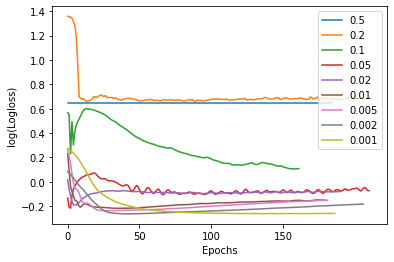

('1e-06', {'EPOCH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181], 'train_loss_list': [1.3790960311889648, 1.0789425373077393, 0.8449634313583374, 0.6981685161590576, 0.5717640519142151, 0.4464212656021118, 0.30410513281822205, 0.220571294426918

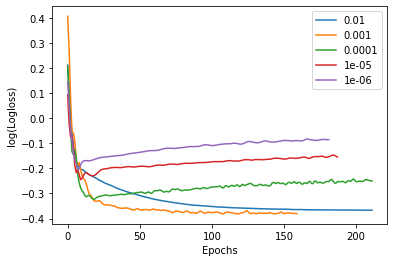

('1', {'EPOCH': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 'train_loss_list': [1.404206395149231, 1.370021939277649, 1.4015512466430664, 1.416990637779

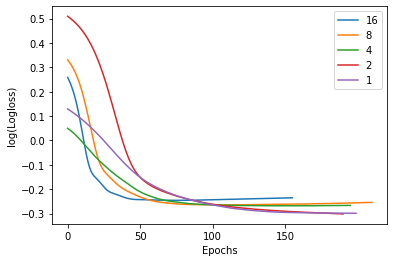

In [40]:
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy import log10


def plot_learning_rate():
    with open("/content/drive/My Drive/Colab Notebooks/learning_rate.json","r") as dump_f:
        load_dict = json.load(dump_f)

    for i,(k,v) in enumerate(load_dict.items()):
        print((k,v))
    keys = list(load_dict.keys())
    keys.reverse()

    # markers = 'v^8sph'
    i = 0
    for key in keys:
        plt.plot(load_dict[key]['EPOCH'],[log10(i) for i in load_dict[key]['val_loss_list']])
        i += 1


    plt.xlabel('Epochs')
    plt.ylabel('log(Logloss)')

    my_x_ticks = np.arange(0, len(load_dict[keys[0]]['EPOCH']), 50)
    plt.xticks(my_x_ticks)

    plt.legend(keys, loc='upper right')
    # plt.figure()
    plt.savefig("/content/drive/My Drive/Colab Notebooks/lr_plot.png",dpi=300)
    plt.show()
    
def plot_weight_decay():
    with open("/content/drive/My Drive/Colab Notebooks/Weight_decay.json","r") as dump_f:
        load_dict = json.load(dump_f)

    for i,(k,v) in enumerate(load_dict.items()):
        print((k,v))
    keys = list(load_dict.keys())
    keys.reverse()

    # markers = 'v^8sph1234Dd'
    i = 0
    for key in keys:
        plt.plot(load_dict[key]['EPOCH'],[log10(i) for i in load_dict[key]['val_loss_list']])
        i += 1


    plt.xlabel('Epochs')
    plt.ylabel('log(Logloss)')

    my_x_ticks = np.arange(0, len(load_dict[keys[0]]['EPOCH']), 50)
    plt.xticks(my_x_ticks)

    plt.legend(keys, loc='upper right')
    # plt.figure()
    plt.savefig("/content/drive/My Drive/Colab Notebooks/wd_plot.png",dpi=300)
    plt.show()

def plot_embed_dim():
    with open("/content/drive/My Drive/Colab Notebooks/EMBED_DIM.json","r") as dump_f:
        load_dict = json.load(dump_f)

    for i,(k,v) in enumerate(load_dict.items()):
        print((k,v))
    keys = list(load_dict.keys())
    keys.reverse()

    # markers = 'v^8sph1234Dd'
    i = 0
    for key in keys:
        plt.plot(load_dict[key]['EPOCH'],[log10(i) for i in load_dict[key]['val_loss_list']])
        i += 1


    plt.xlabel('Epochs')
    plt.ylabel('log(Logloss)')

    my_x_ticks = np.arange(0, len(load_dict[keys[0]]['EPOCH']), 50)
    plt.xticks(my_x_ticks)

    plt.legend(keys, loc='upper right')
    # plt.figure()
    plt.savefig("/content/drive/My Drive/Colab Notebooks/ed_plot.png",dpi=300)
    plt.show()

def plot_one_learning_rate():
    with open("/content/drive/My Drive/Colab Notebooks/learning_rate.json","r") as dump_f:
        load_dict = json.load(dump_f)

    for i,(k,v) in enumerate(load_dict.items()):
        print((k,v))
    keys = list(load_dict.keys())

    key = keys[0]
    epoch = load_dict[key]['EPOCH']
    train_loss = load_dict[key]['train_loss_list']
    val_loss = load_dict[key]['val_loss_list']
    val_auc = [i for i in load_dict[key]['val_auc_list']]
    val_acc = [i/100 for i in load_dict[key]['val_acc_list']]


    plt.plot(epoch,train_loss)
    plt.plot(epoch, val_loss)
    plt.plot(epoch, val_auc)
    plt.plot(epoch, val_acc)

    plt.legend(['train_loss', 'val_loss','val_auc','val_acc'], loc='upper left')
    plt.show()

plot_learning_rate()
plot_weight_decay()
plot_embed_dim()
